# 5.1 Criação de Modelos de Machine Learning - Tunning

In [35]:
# ! pip install seaborn
# ! pip install plotly
# ! pip install statsmodels
# ! pip install sklearn

In [36]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split


from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import RandomizedSearchCV

import joblib

### Carregar dados tratados

In [37]:
def carregar_joblib(file_name: str = "../out/result_analise_desc.joblib"):
    df = joblib.load(file_name)
    return df

### Separar base

In [38]:
def split_dados(df, test_size: float = 0.2):
    X = df.drop(["decisao"], axis=1)
    y = df["decisao"]

    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=test_size, random_state=42)

    return (X_treino, X_teste, y_treino, y_teste)

### Funcoes para avaliacao do modelo

In [39]:
def plot_confusion_matrix_heat(cf_matrix):
    cf_matrix.index.name = 'Atual'
    cf_matrix.columns.name = 'Predito'
    
    cf_nd_array = cf_matrix.to_numpy()
    cf_flatten = cf_nd_array.flatten()

    group_names = ["TN", "FP", "FN", "TP"]
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_flatten]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_flatten / np.sum(cf_nd_array)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    print(cf_matrix.shape)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

In [55]:
def avaliar(y_teste, y_prev, nome_modelo):
    print(nome_modelo)
    report = classification_report(y_teste, y_prev, target_names=["Vender", "Comprar"])
    print("Report\n", report)
    cf_matrix = pd.DataFrame(confusion_matrix(y_teste, y_prev), index=["Vender", "Comprar"], columns=["Vender", "Comprar"])
    plot_confusion_matrix_heat(cf_matrix)
    plt.show()
    metric = metrics.precision_score(y_teste, y_prev)
    print(f"Precision: {metric}\n\n")
    return metric

# ML modelos

## Modelos a serem testados

- AdaBoost
- Random Forest
- Logistic Regression

In [41]:
def definir_modelos_ml() -> dict:
    return {
        "AdaBoost": {'modelo_base': AdaBoostClassifier(), 'modelo_tunado': None},
        "LogisticRegression": {'modelo_base': LogisticRegression(random_state=42), 'modelo_tunado': None},
        "RandomForrest": {'modelo_base': RandomForestClassifier(random_state=42), 'modelo_tunado': None},
    }

In [42]:
def treinar_modelo_base(modelos, splited_dados):

    X_treino, _, y_treino, _ = splited_dados

    for nome, modelo in modelos.items():
        modelo = modelo.get('modelo_base')
        modelo.fit(X_treino, y_treino)
        modelos[nome]['modelo_base'] = modelo
    
    return modelos

## Tunning dos 3 melhores modelos

### AdaBoost Tunning

In [43]:
def fit_tunning_rand_search_ada(X_treino, y_treino):
    param = {'n_estimators': [50, 80, 90, 100],
             'learning_rate': [0.2, 1.0, 0.1],
             'algorithm': ["SAMME", "SAMME.R"], 
             'random_state':[None]}

    rf_random = RandomizedSearchCV(estimator=AdaBoostClassifier(),
                                   param_distributions=param,
                                   cv=10,
                                   verbose=0,
                                   scoring="precision",
                                   random_state=42,
                                   n_jobs=-1)

    # Fit the random search model
    return rf_random.fit(X_treino, y_treino)

def run_ada_boost_tunning(splited_data):

    X_treino, X_teste, y_treino, y_teste = splited_data
    
    resultado_grid = fit_tunning_rand_search_ada(X_treino.values, y_treino.values)

    print("Best params Adaboost", resultado_grid.best_params_)

    modelo_tunado = resultado_grid.best_estimator_

    return modelo_tunado

### Random Forest Tunning

In [44]:
def fit_tunning_rand_search_rand_forest(X_treino, y_treino):
    param = {
             "criterion": ["entropy"],
             "n_estimators": [100],
             "max_depth": [None],
             "min_samples_split": [2, 3],
             "min_samples_leaf": [1, 2, 3],
             "min_weight_fraction_leaf": [0],
             'max_features': ["auto"],
             'warm_start': [True],
             'random_state': [None],
             'n_jobs': [-1],
            }

    rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(),
                                   param_distributions=param,
                                   cv=10,
                                   verbose=0,
                                   scoring="precision",
                                   random_state=42,
                                   n_jobs=-1)

    # Fit the random search model
    return rf_random.fit(X_treino, y_treino)


def run_rand_forest_tunning(splited_dados):

    X_treino, X_teste, y_treino, y_teste = splited_dados
    
    resultado_grid = fit_tunning_rand_search_rand_forest(X_treino, y_treino)

    print("Best params Rand Forest", resultado_grid.best_params_)

    modelo_tunado = resultado_grid.best_estimator_

    return modelo_tunado

### Logistic Regression Tunning

In [45]:
def fit_tunning_rand_search_log_reg(X_treino, y_treino):
    param = {
             "solver": ["lbfgs"],
             "penalty": ["l2", "none"],
             "dual": [False],
             "tol": [0.0001],
             "C": [1.0],
             "fit_intercept": [True],
             'class_weight': [False, "balanced"],
             'multi_class': ["ovr", "auto"],
             'warm_start': [False, True],
             'random_state': [42, 2, None],
             'n_jobs': [-1],
            }

    rf_random = RandomizedSearchCV(estimator=LogisticRegression(max_iter=300),
                                   param_distributions=param,
                                   cv=10,
                                   verbose=0,
                                   scoring="average_precision",
                                   random_state=42,
                                   n_jobs=-1)

    # Fit the random search model
    return rf_random.fit(X_treino, y_treino)

def run_log_reg_tunning(splited_dados):

    X_treino, X_teste, y_treino, y_teste = splited_dados
    
    resultado_grid = fit_tunning_rand_search_log_reg(X_treino, y_treino)

    print("Best params Logistic Regression", resultado_grid.best_params_)

    modelo_tunado = resultado_grid.best_estimator_

    return modelo_tunado

### Rodar tunnings por modelo e guardar

In [47]:
def run_tunning_fit(df, modelos, splited_data):
    '''
        Executa os tunnings com randomized search cv e armazena o modelo tunado
    '''
    modelos['AdaBoost']['modelo_tunado'] = run_ada_boost_tunning(splited_data)
    modelos['RandomForrest']['modelo_tunado'] = run_rand_forest_tunning(splited_data)
    
    splited_data = split_dados(df, test_size=0.2)
    modelos['LogisticRegression']['modelo_tunado'] = run_log_reg_tunning(splited_data)

    return modelos


## Execucao ML Tunning

In [53]:
def main_trainining():

    df = carregar_joblib()

    splited_data = split_dados(df, test_size=0.2)

    modelos = definir_modelos_ml()

    modelos = treinar_modelo_base(modelos, splited_data)

    modelos = run_tunning_fit(df, modelos, splited_data)

    return modelos, splited_data

modelos, splited_data = main_trainining()

Best params Adaboost {'random_state': None, 'n_estimators': 50, 'learning_rate': 1.0, 'algorithm': 'SAMME.R'}


/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params Rand Forest {'warm_start': True, 'random_state': None, 'n_jobs': -1, 'n_estimators': 100, 'min_weight_fraction_leaf': 0, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'criterion': 'entropy'}
----- * ---------- * ---------- * ---------- * ---------- * -----
Best params Logistic Regression {'warm_start': True, 'tol': 0.0001, 'solver': 'lbfgs', 'random_state': 42, 'penalty': 'none', 'n_jobs': -1, 'multi_class': 'auto', 'fit_intercept': True, 'dual': False, 'class_weight': False, 'C': 1.0}


## Comparar modelos treinados

In [82]:
def plot_compare_bar(metrics: dict):
    # barplot comparacao 3 modelos tunados
    sns.set_theme(style="whitegrid")
    x_labels = ["adaBoost", "adaBoost\ntunned", "LogReg", "LogReg\ntunned", "RandForr", "RandForr\ntunned"]
    ax = sns.barplot(x=x_labels, y=list(metrics.values()))
    ax.set(xlabel="Modelos", ylabel="Precisão", title="Precisão por Modelo")

In [64]:
def compare_tunning(modelos: dict, splited_data):

    _, X_teste, _, y_teste = splited_data

    metrics = {}
    for nome, modelos_dict in modelos.items():
        prev = modelos_dict['modelo_base'].predict(X_teste)
        metrics[nome + '_base'] =  avaliar(y_teste, prev, nome + '_base')
        prev = modelos_dict['modelo_tunado'].predict(X_teste)
        metrics[nome + '_tunned'] = avaliar(y_teste, prev, nome + '_tunado')
        print("-*" * 50)
        print("\n")    
    
    plot_compare_bar(metrics)

AdaBoost_base
Report
               precision    recall  f1-score   support

      Vender       0.56      0.47      0.51       186
     Comprar       0.54      0.64      0.59       185

    accuracy                           0.55       371
   macro avg       0.55      0.55      0.55       371
weighted avg       0.55      0.55      0.55       371

(2, 2)


/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


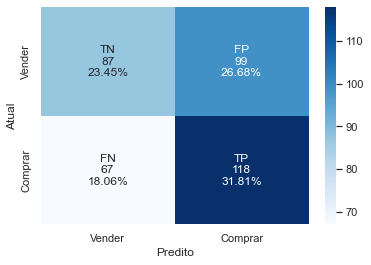

/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


Precision: 0.543778801843318


AdaBoost_tunado
Report
               precision    recall  f1-score   support

      Vender       0.56      0.47      0.51       186
     Comprar       0.54      0.64      0.59       185

    accuracy                           0.55       371
   macro avg       0.55      0.55      0.55       371
weighted avg       0.55      0.55      0.55       371

(2, 2)


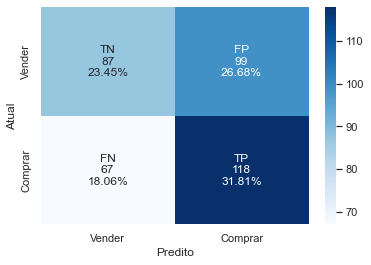

Precision: 0.543778801843318


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


LogisticRegression_base
Report
               precision    recall  f1-score   support

      Vender       0.57      0.57      0.57       186
     Comprar       0.57      0.57      0.57       185

    accuracy                           0.57       371
   macro avg       0.57      0.57      0.57       371
weighted avg       0.57      0.57      0.57       371

(2, 2)


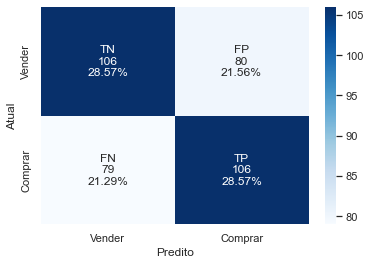

Precision: 0.5698924731182796


LogisticRegression_tunado
Report
               precision    recall  f1-score   support

      Vender       0.57      0.59      0.58       186
     Comprar       0.58      0.56      0.57       185

    accuracy                           0.57       371
   macro avg       0.57      0.57      0.57       371
weighted avg       0.57      0.57      0.57       371

(2, 2)


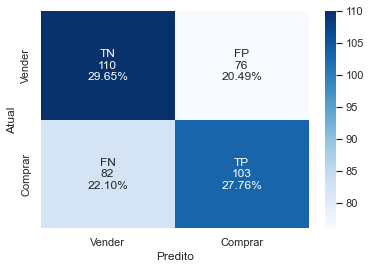

Precision: 0.5754189944134078


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*


RandomForrest_base
Report
               precision    recall  f1-score   support

      Vender       0.54      0.51      0.52       186
     Comprar       0.53      0.56      0.54       185

    accuracy                           0.53       371
   macro avg       0.53      0.53      0.53       371
weighted avg       0.53      0.53      0.53       371

(2, 2)


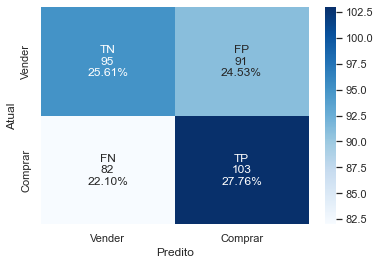

Precision: 0.5309278350515464


RandomForrest_tunado
Report
               precision    recall  f1-score   support

      Vender       0.54      0.53      0.54       186
     Comprar       0.54      0.56      0.55       185

    accuracy                           0.54       371
   macro avg       0.54      0.54      0.54       371
weighted avg       0.54      0.54      0.54       371

(2, 2)


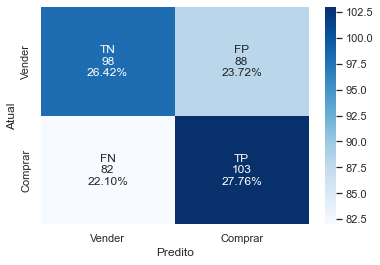

Precision: 0.5392670157068062


-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*




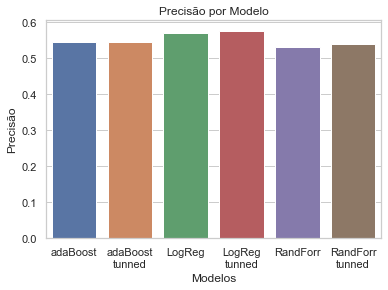

In [83]:
compare_tunning(modelos, splited_data)

# Melhor modelo escolhido:

- Logistic Regression

Best precision 57,54%

Modelo com poucos Falsos Positivos, e bom balenceamento entre TN e TP